<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-from-S3" data-toc-modified-id="Read-from-S3-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read from S3</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#SHAP-analysis" data-toc-modified-id="SHAP-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SHAP analysis</a></span></li><li><span><a href="#Grid-search-regularization-parameter" data-toc-modified-id="Grid-search-regularization-parameter-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Grid search regularization parameter</a></span></li><li><span><a href="#Create-Final-Model-and-Save-Model" data-toc-modified-id="Create-Final-Model-and-Save-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create Final Model and Save Model</a></span></li><li><span><a href="#Upload-Model-to-S3" data-toc-modified-id="Upload-Model-to-S3-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Upload Model to S3</a></span></li><li><span><a href="#Get-Threshold-of-Top-2.5%-of-data" data-toc-modified-id="Get-Threshold-of-Top-2.5%-of-data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Get Threshold of Top 2.5% of data</a></span></li></ul></div>

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import utils
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import SparkSession
import os
import pandas as pd

os.environ['TZ'] = 'UTC'

# Read from S3

After the data has been collected, the dataset size is relatively small with significant reduction over scraped dataset.

In [16]:
filename = 's3a://data-kennethmyers/model_data/redditAggregatedData-20230502.parquet'

In [17]:
cfg_file = utils.findConfig()
cfg = utils.parseConfig(cfg_file)
spark = (
  SparkSession
  .builder
  .appName('redditData')
  .config('spark.driver.extraJavaOptions', '-Duser.timezone=GMT') 
  .config('spark.executor.extraJavaOptions', '-Duser.timezone=GMT')
  .config('spark.sql.session.timeZone', 'UTC')
  .config("fs.s3a.access.key", cfg['ACCESSKEY'])
  .config("fs.s3a.secret.key", cfg['SECRETKEY'])
  .getOrCreate()
)
df = spark.read.parquet(filename).toPandas()
spark.stop()  # we don't need spark now

# Model

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler

In [19]:
df = df.fillna(0)

In [20]:
# testing some new features, 
# did not want to add these to the ETL work until understanding them better
def timeFeatures(df):
  df = df.copy()
  # make it timezone aware
  df['createdTSUTC'] = df['createdTSUTC'].dt.tz_localize('UTC')
  # convert to EST
  df['createdTSEST'] = df['createdTSUTC'].dt.tz_convert('US/Eastern')
  
  df['hour'] = df['createdTSEST'].apply(lambda x: x.hour)
  df['dayofweek'] = df['createdTSEST'].apply(lambda x: x.dayofweek)
  
  df['time0006'] = df['hour'].apply(lambda x: 1 if 0 <= x < 6 else 0)
  df['time0612'] = df['hour'].apply(lambda x: 1 if 6 <= x < 12 else 0)
  df['time1218'] = df['hour'].apply(lambda x: 1 if 12 <= x < 18 else 0)
  df['time1800'] = df['hour'].apply(lambda x: 1 if 18 <= x else 0)
  df['sunday'] = df['dayofweek'].apply(lambda x: 1 if x == 6 else 0)
  
  return df

In [21]:
df = timeFeatures(df)

In [22]:
# adding a random variable, I like to see how it performs against other variables
df['randomVar'] = np.random.binomial(1, df['target'].mean(), len(df))

In [23]:
def plotPrecRecAUCPR(X_train, y_train, X_test, y_test):
  lr = LogisticRegression(penalty='l2', fit_intercept=True, C=.01)
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  y_pred_proba = lr.predict_proba(X_test)[:, 1]
  # print(f"accuracy: {accuracy_score(y_test,y_pred)}") # doesn't mean much with imbalanced data
  # print(f"precision: {precision_score(y_test,y_pred)}")
  # print(f"recall: {recall_score(y_test,y_pred)}")
  precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
  aucpr = auc(recalls, precisions)
  print(f"AUCPR: {aucpr:.04f}")

  coefFeatures = np.concatenate((lr.feature_names_in_,np.array(['intercept'])))
  coefValues = np.concatenate((lr.coef_[0],lr.intercept_))
  coefDf = pd.DataFrame(list(zip(coefFeatures, coefValues)), columns=['feature', 'coef'])
  coefDf['coefPct'] = (np.abs(coefDf['coef'])/np.abs(coefDf['coef']).sum()).apply(lambda x: f"{x:.06f}")
  print(coefDf.to_string())

  topQuantiles = np.arange(.95,1,0.005)
  topQuantilesThresholds = np.quantile(y_pred_proba, topQuantiles)
  totalTargets = y_test.sum()
  topQPrecisions = [y_test[y_pred_proba>=t].mean() for t in topQuantilesThresholds]
  topQRecalls = [y_test[y_pred_proba>=t].sum()/totalTargets for t in topQuantilesThresholds]

  fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False, squeeze=False)

  axes[0,0].plot(topQuantiles, topQPrecisions)
  axes[0,0].set_title(f'Precisions against quantile')
  axes[0,0].set_ylim([0,1.05])
  axes[0,0].set_xlabel('quantile')
  axes[0,0].set_ylabel('precisions')

  axes[0,1].plot(topQuantiles, topQRecalls)
  axes[0,1].set_title(f'Recalls against quantile')
  axes[0,1].set_ylim([0,1.05])
  axes[0,1].set_xlabel('quantile')
  axes[0,1].set_ylabel('recalls')

  axes[0,2].plot(recalls, precisions)
  axes[0,2].set_title(f'AUCPR={aucpr:.04f}')
  axes[0,2].set_xlabel('recalls')
  axes[0,2].set_ylabel('precisions')

  plt.show()
  
  return y_pred_proba

total posts: 5627, viral posts: 147
AUCPR: 0.6145
                             feature      coef   coefPct
0                     maxScore21_40m -0.126763  0.020728
1                     maxScore41_60m  0.123735  0.020232
2               maxNumComments21_40m -0.022204  0.003631
3               maxNumComments41_60m  0.093221  0.015243
4               maxUpvoteRatio21_40m  0.031281  0.005115
5               maxUpvoteRatio41_60m  0.038939  0.006367
6         maxScoreGrowth21_40m41_60m  0.106731  0.017452
7   maxNumCommentsGrowth21_40m41_60m  0.145153  0.023734
8                          randomVar  0.007060  0.001154
9                           time0006  0.034445  0.005632
10                          time0612  0.107231  0.017534
11                          time1800 -0.139254  0.022770
12                         intercept -5.139687  0.840408


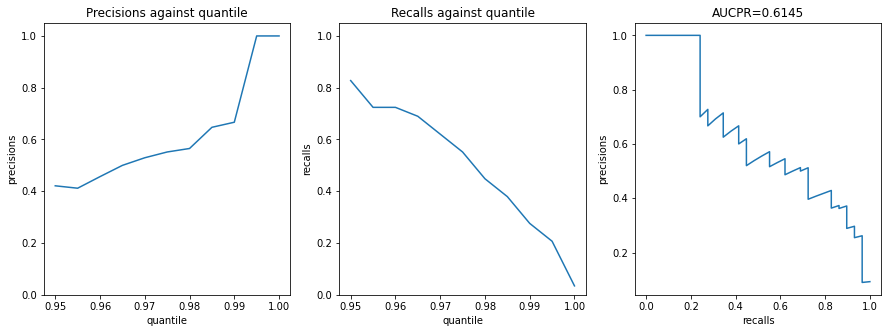

In [24]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_std, X_test_std = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns), scaler.transform(X_test)
 
features = [
  #'maxScore20m',
  'maxScore21_40m',
  'maxScore41_60m',
  #'maxNumComments20m',
  'maxNumComments21_40m',
  'maxNumComments41_60m',
#   'maxUpvoteRatio20m', 
  'maxUpvoteRatio21_40m',
  'maxUpvoteRatio41_60m',
#   'maxNumGildings20m',  # we know these are bad features from prior analysis
#   'maxNumGildings21_40m',
#   'maxNumGildings41_60m',
  'maxScoreGrowth21_40m41_60m',
  'maxNumCommentsGrowth21_40m41_60m',
  'randomVar',
  'time0006', 
  'time0612',
#   'time1218',
  'time1800',
#   'sunday'
]

X = df[features]
y = df['target']
print(f"total posts: {len(y)}, viral posts: {y.sum()}")  # how many targets are there, This is a highly imbalanced problem, only ~2.5% of posts in rising go viral

sss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=0)
train_index, test_index = next(sss.split(X,y))
X_train, y_train, X_test, y_test = X.iloc[train_index], y.iloc[train_index], X.iloc[test_index], y.iloc[test_index]

y_pred_proba = plotPrecRecAUCPR(X_train, y_train, X_test, y_test)

This is a pretty good model so far. There seems to be evidence for removing the upvote ratio features. I ran an experiment without them (not shown here) and it seemed to perform well without them but I want to experiment more before making a decision.

In [25]:
# sorted top 10 predictions
sorted(list(zip(y_pred_proba, y_test)), key=lambda x:x[0])[::-1][:10]

[(0.9999999999956717, 1),
 (0.9999992847009377, 1),
 (0.9999930992822691, 1),
 (0.9995904818731838, 1),
 (0.9860530617770333, 1),
 (0.9220302853709107, 1),
 (0.9168512867999792, 1),
 (0.8981732648585833, 0),
 (0.8873146724555911, 0),
 (0.7573121283892941, 0)]

It is cool to see many of the posts being scored at the top.

In [30]:
# I wanted to see some data on the viral posts (why were some accurately predicted and some not)
# and the posts that had high viral probability but were considered non-viral
def getOriginalPostId(df, test_index, y_test, y_pred_proba, threshold):
  fullTestData = df.iloc[test_index].copy(deep=True)
  fullTestData['prediction'] = y_pred_proba
  fullTestData['link'] = fullTestData['postId'].apply(lambda x: "https://reddit.com/"+x)
  target1Indexes = np.where(y_test==1)[0]
  viralPosts = fullTestData[fullTestData['target']==1].sort_values('prediction', ascending=False)
  nonViralPosts = fullTestData[fullTestData['target']==0].sort_values('prediction', ascending=False)
  nonViralPosts = nonViralPosts[nonViralPosts['prediction']>=threshold]
  
  p = len(viralPosts)
  tp = len(viralPosts[viralPosts['prediction']>=threshold])
  fp = len(nonViralPosts)
    
  print(f"recall = {tp/p}")
  print(f"precision = {tp/(tp+fp)}")

  return pd.concat([viralPosts, nonViralPosts], axis=0)[['target', 'postId', 'link', 'prediction', 'createdTSUTC']+features]


getOriginalPostId(df, test_index, y_test, y_pred_proba, threshold=0.100)

recall = 0.6896551724137931
precision = 0.5


,target,postId,link,prediction,createdTSUTC,maxScore21_40m,maxScore41_60m,maxNumComments21_40m,maxNumComments41_60m,maxUpvoteRatio21_40m,maxUpvoteRatio41_60m,maxScoreGrowth21_40m41_60m,maxNumCommentsGrowth21_40m41_60m,randomVar,time0006,time0612,time1800
3651,1,135tlqe,https://reddit.com/135tlqe,1.000000,2023-05-02 16:56:49+00:00,80.0,301.0,13.0,41.0,0.84,0.90,2.762500,2.153846,0,0,0,0
3479,1,12z2v8n,https://reddit.com/12z2v8n,0.999999,2023-04-26 01:48:36+00:00,58.0,180.0,29.0,51.0,0.94,0.90,2.103448,0.758621,0,0,0,1
3659,1,12s2767,https://reddit.com/12s2767,0.999993,2023-04-19 16:40:28+00:00,58.0,167.0,17.0,39.0,0.91,0.95,1.879310,1.294118,0,0,0,0
1786,1,134omh1,https://reddit.com/134omh1,0.999590,2023-05-01 14:51:49+00:00,43.0,108.0,21.0,53.0,0.92,0.88,1.511628,1.523810,0,0,1,0
5233,1,132gkp5,https://reddit.com/132gkp5,0.986053,2023-04-29 02:11:53+00:00,55.0,114.0,12.0,25.0,0.97,0.96,1.072727,1.083333,0,0,0,1
3529,1,12lxody,https://reddit.com/12lxody,0.922030,2023-04-14 13:41:09+00:00,27.0,57.0,16.0,41.0,0.88,0.84,1.111111,1.562500,0,0,1,0
3096,1,13637rz,https://reddit.com/13637rz,0.916851,2023-05-02 22:59:56+00:00,38.0,89.0,12.0,16.0,0.95,0.96,1.342105,0.333333,0,0,0,1
1933,1,131q4lm,https://reddit.com/131q4lm,0.712528,2023-04-28 12:21:03+00:00,28.0,45.0,27.0,46.0,0.96,0.92,0.607143,0.703704,0,0,1,0
3465,1,12qynw7,https://reddit.com/12qynw7,0.628524,2023-04-18 18:08:05+00:00,41.0,70.0,11.0,23.0,0.97,0.96,0.707317,1.090909,0,0,0,0
1973,1,12iolqv,https://reddit.com/12iolqv,0.612768,2023-04-11 16:07:21+00:00,29.0,67.0,6.0,9.0,0.95,0.94,1.310345,0.500000,0,0,0,0


I created the above to spotcheck a few examples. The 2 that I failed to predict were both pretty viral (exceeding two I succeeded in predicting) despite having relatively weak metrics (3 comments after an hour, <25 upvotes after an hour). This shows that there is pretty good lag in posts going viral and that perhaps more than an hour is needed to accurately predict virality. Another thing I noticed was that those two posts were both about tragedies, so perhaps there there is something about tragedies going extremely viral but are slower to gain traction.

The three posts that were predicted to go viral but ultimately were not all had pretty high upvote counts after the first hour but must have lost traction afterwards, this is further evidence that maybe it would be better to extend the data collection another 30-60 minutes.

# SHAP analysis

For imbalanced datasets, I like to look at the SHAP values for the target of interest (viral posts).

In [75]:
import shap

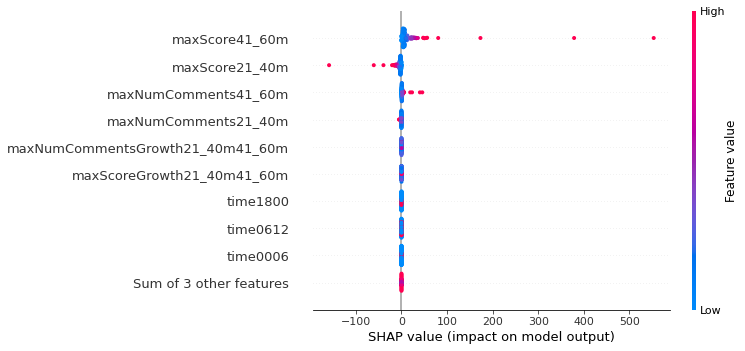

In [76]:
# https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html
lr = LogisticRegression(penalty='l2', fit_intercept=True, C=.01)
lr.fit(X, y)
explainer = shap.Explainer(lr, X, feature_names=X.columns)
shap_values = explainer(X)
shap_values_0 = explainer(X[y==0])
shap_values_1 = explainer(X[y==1])

shap.plots.beeswarm(shap_values_1, show=False)
ax = plt.gca()
# You can change the min and max value of xaxis by changing the arguments of:
#ax.set_xlim(-3, 3) 
plt.show()

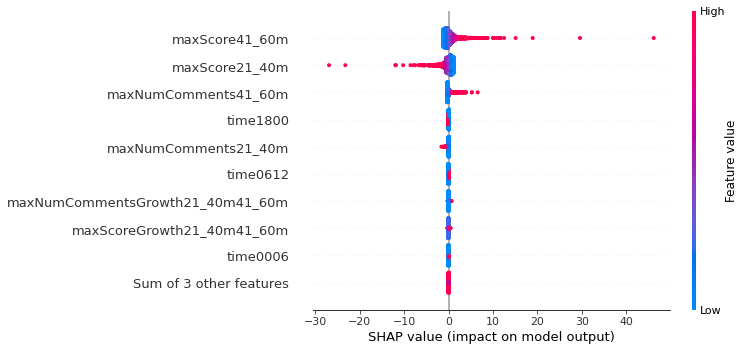

In [77]:
shap.plots.beeswarm(shap_values_0, show=False)
ax = plt.gca()
# You can change the min and max value of xaxis by changing the arguments of:
#ax.set_xlim(-3, 3) 
plt.show()

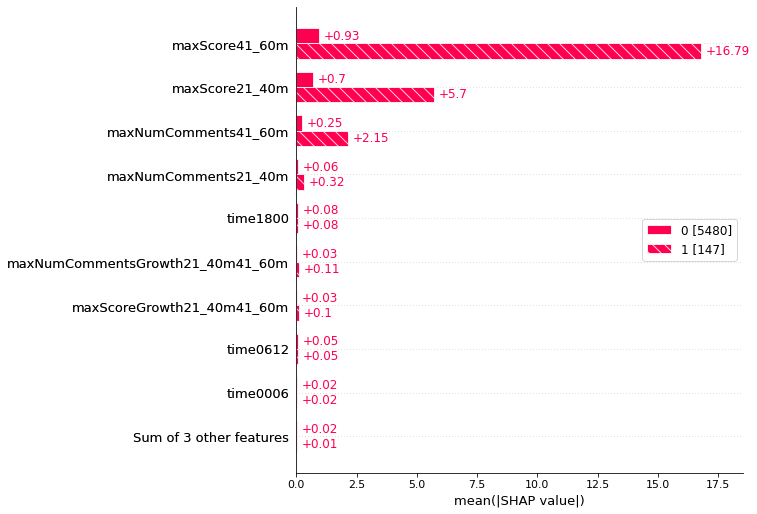

In [78]:
shap.plots.bar(shap_values.cohorts([i for i in map(str, y.values)]).abs.mean(0), show=False)

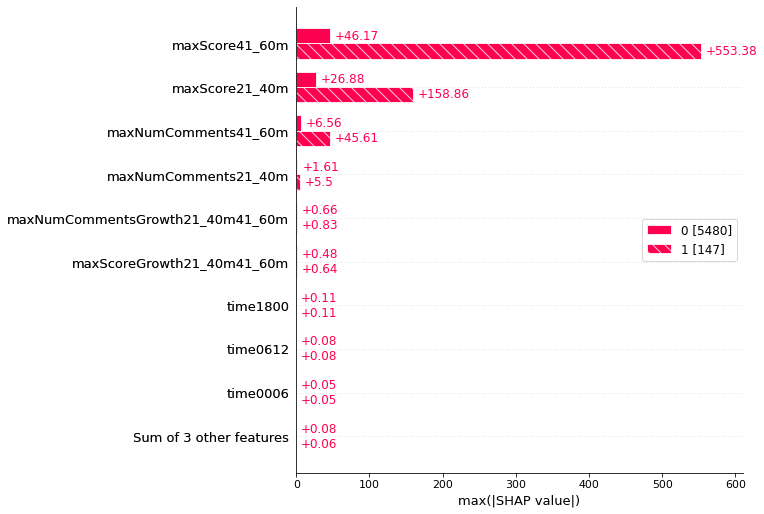

In [79]:
shap.plots.bar(shap_values.cohorts([i for i in map(str, y.values)]).abs.max(0), show=False)


# Grid search regularization parameter

Here I'm removing features based on the above findings, then I want to check how the model performs on different splits.

I'm removing the randomVar and the upvoteRatio features since they seem to be the least useful.

In [80]:
from collections import defaultdict

C_values = [1, 0.5, 0.25, 0.1, 0.01, 0.001, 0.0001, 0.00001]

features = [
  #'maxScore20m',
  'maxScore21_40m',
  'maxScore41_60m',
  #'maxNumComments20m',
  'maxNumComments21_40m',
  'maxNumComments41_60m',
#   'maxUpvoteRatio20m', 
  'maxUpvoteRatio21_40m',
  'maxUpvoteRatio41_60m',
#   'maxNumGildings20m',  # we know these are bad features from prior analysis
#   'maxNumGildings21_40m',
#   'maxNumGildings41_60m',
  'maxScoreGrowth21_40m41_60m',
  'maxNumCommentsGrowth21_40m41_60m',
#   'randomVar',
  'time0006', 
  'time0612',
#   'time1218',
  'time1800',
#   'sunday'
]

X = df[features]
y = df['target']
print(f"total posts: {len(y)}, viral posts: {y.sum()}")  # how many targets are there, This is a highly imbalanced problem, only ~2.5% of posts in rising go viral

sss = StratifiedShuffleSplit(n_splits=10, train_size=0.8, test_size=0.2, random_state=0)

aucprs = defaultdict(list)
top2PctPrecisions = defaultdict(list)
top2PctRecalls = defaultdict(list)

for c in C_values:
  print(f'collecting data for C={c}')
  for i, (train_index, test_index) in enumerate(sss.split(X,y)):
    X_train, y_train, X_test, y_test = X.iloc[train_index], y.iloc[train_index], X.iloc[test_index], y.iloc[test_index]
    lr = LogisticRegression(penalty='l2', fit_intercept=True, C=c, max_iter=1000)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    y_pred_proba = lr.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
  #   topQuantiles = np.arange(.95,1,0.005)
    top2PctThreshold2 = np.quantile(y_pred_proba, 0.98)
    totalTargets = y_test.sum()
    top2PctPrecision = y_test[y_pred_proba>=top2PctThreshold2].mean()
    top2PctRecall = y_test[y_pred_proba>=top2PctThreshold2].sum()/totalTargets
    aucpr = auc(recalls, precisions)
    aucprs[c].append(aucpr)
    top2PctPrecisions[c].append(top2PctPrecision)
    top2PctRecalls[c].append(top2PctRecall)
  
  
  
dfDict = {
  'C':C_values,
  'AUCPRmean':[],
  'AUCPRstd':[],
  'top2PctPrecisionmean':[],
  'top2PctPrecisionstd':[],
  'top2PctRecallmean':[],
  'top2PctRecallstd':[],
}
for c in C_values:
  dfDict['AUCPRmean'].append(np.mean(aucprs[c]))
  dfDict['AUCPRstd'].append(np.std(aucprs[c]))
  dfDict['top2PctPrecisionmean'].append(np.mean(top2PctPrecisions[c]))
  dfDict['top2PctPrecisionstd'].append(np.std(top2PctPrecisions[c]))
  dfDict['top2PctRecallmean'].append(np.mean(top2PctRecalls[c]))
  dfDict['top2PctRecallstd'].append(np.std(top2PctRecalls[c]))

display(pd.DataFrame(dfDict))

total posts: 5627, viral posts: 147
collecting data for C=1
collecting data for C=0.5
collecting data for C=0.25
collecting data for C=0.1
collecting data for C=0.01
collecting data for C=0.001
collecting data for C=0.0001
collecting data for C=1e-05


,C,AUCPRmean,AUCPRstd,top2PctPrecisionmean,top2PctPrecisionstd,top2PctRecallmean,top2PctRecallstd
0,1.00000,0.636688,0.076513,0.617391,0.060870,0.489655,0.048276
1,0.50000,0.638179,0.075062,0.621739,0.072883,0.493103,0.057804
2,0.25000,0.638927,0.072691,0.621739,0.072883,0.493103,0.057804
3,0.10000,0.639775,0.065533,0.617391,0.066793,0.489655,0.052973
4,0.01000,0.622852,0.063577,0.613043,0.059773,0.486207,0.047406
5,0.00100,0.589511,0.071633,0.595652,0.064635,0.472414,0.051262
6,0.00010,0.555989,0.074768,0.547826,0.065072,0.434483,0.051609
7,0.00001,0.541937,0.074322,0.521739,0.067356,0.413793,0.053420


Based on this it seems that more regularization has diminishing returns near the area where I was planning to choose my cutoff. I'll probably settle on a regularizer of C~0.25

# Create Final Model and Save Model

Final model is just going to use all of the data. This isn't typical practice but we don't have a lot of data so I want to use all of the data available. 

In [82]:
features = [
  #'maxScore20m',
  'maxScore21_40m',
  'maxScore41_60m',
  #'maxNumComments20m',
  'maxNumComments21_40m',
  'maxNumComments41_60m',
#   'maxUpvoteRatio20m', 
  'maxUpvoteRatio21_40m',
  'maxUpvoteRatio41_60m',
#   'maxNumGildings20m',  # we know these are bad features from prior analysis
#   'maxNumGildings21_40m',
#   'maxNumGildings41_60m',
  'maxScoreGrowth21_40m41_60m',
  'maxNumCommentsGrowth21_40m41_60m',
#   'randomVar',
  'time0006', 
  'time0612',
#   'time1218',
  'time1800',
#   'sunday'
]

c=0.25
X = df[features]
y = df['target']
print(f"total posts: {len(y)}, viral posts: {y.sum()}")  # how many targets are there, This is a highly imbalanced problem, only ~2.5% of posts in rising go viral

lr = LogisticRegression(penalty='l2', fit_intercept=True, C=c, max_iter=1000)
lr.fit(X, y)


total posts: 5627, viral posts: 147


LogisticRegression(C=0.25, max_iter=1000)

In [83]:
import pickle
from datetime import datetime

now = datetime.utcnow().strftime('%Y%m%d-%H%M%S')
filename = f'./pickledModels/Reddit_model_{now}_LR.sav'
pickle.dump(lr, open(filename, 'wb'))

In [84]:
# testing the model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict_proba(X)
print(result)

[[0.99410761 0.00589239]
 [0.99165896 0.00834104]
 [0.99720599 0.00279401]
 ...
 [0.99036186 0.00963814]
 [0.99752091 0.00247909]
 [0.9925462  0.0074538 ]]


# Upload Model to S3

In [85]:
import boto3

s3 = boto3.client('s3', region_name='us-east-2')

response = s3.upload_file(filename, "data-kennethmyers", f"models/{filename.split('/')[-1]}")

# Get Threshold of Top 2.5% of data

Really this should be done with a holdout set, but I don't have enough data right now so I'm just going to generate it from the in-sample data. We can always adjust the threshold later.

In [88]:
y_pred_proba = lr.predict_proba(X[lr.feature_names_in_])[:, 1]
threshold = np.quantile(y_pred_proba, 0.975)
threshold

0.18476174783113303

In [89]:
# this was defined earlier
getOriginalPostId(df, list(range(len(df))), y, y_pred_proba, threshold)

recall = 0.564625850340136
precision = 0.5886524822695035


,target,postId,link,prediction,createdTSUTC,maxScore21_40m,maxScore41_60m,maxNumComments21_40m,maxNumComments41_60m,maxUpvoteRatio21_40m,maxUpvoteRatio41_60m,maxScoreGrowth21_40m41_60m,maxNumCommentsGrowth21_40m41_60m,time0006,time0612,time1800
730,1,12uqjis,https://reddit.com/12uqjis,1.000000,2023-04-22 01:46:42+00:00,321.0,1410.0,156.0,401.0,0.96,0.96,3.392523,1.570513,0,0,1
2106,1,12q3ti7,https://reddit.com/12q3ti7,1.000000,2023-04-18 00:44:08+00:00,489.0,3070.0,47.0,191.0,0.92,0.93,5.278119,3.063830,0,0,1
1919,1,12mh34c,https://reddit.com/12mh34c,1.000000,2023-04-14 23:04:35+00:00,139.0,661.0,87.0,231.0,0.94,0.92,3.755396,1.655172,0,0,1
3453,1,12ns07x,https://reddit.com/12ns07x,1.000000,2023-04-16 02:35:37+00:00,1265.0,4481.0,177.0,452.0,0.99,0.98,2.542292,1.553672,0,0,1
3073,1,12zgm03,https://reddit.com/12zgm03,1.000000,2023-04-26 12:52:26+00:00,117.0,448.0,9.0,28.0,0.94,0.95,2.829060,2.111111,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3320,0,12hjgow,https://reddit.com/12hjgow,0.203262,2023-04-10 13:52:43+00:00,3.0,6.0,14.0,27.0,0.67,0.69,1.000000,0.928571,0,1,0
3905,0,12ygrm5,https://reddit.com/12ygrm5,0.192477,2023-04-25 11:37:38+00:00,17.0,41.0,3.0,2.0,0.95,0.97,1.411765,-0.333333,0,1,0
2490,0,12iq49b,https://reddit.com/12iq49b,0.189732,2023-04-11 17:01:09+00:00,41.0,68.0,6.0,7.0,0.96,0.97,0.658537,0.166667,0,0,0
3633,0,12jl7uq,https://reddit.com/12jl7uq,0.186874,2023-04-12 12:50:08+00:00,28.0,42.0,2.0,6.0,0.91,0.92,0.500000,2.000000,0,1,0
